# **Final Assignment - Drift Diffusion Modeling**

**Course:** Cognitive Modelling  
**Dataset 6:** Distractor Effects in Lexical Decision  
**Student:** Sarah Lobis  
**Date:** 20.12.2025

In [1]:
# If running through Google Colab, uncomment next line to install pyddm
# !pip -q install pyddm

In [2]:
# ==========================================
# 0. Setup: Install & imports
# ==========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import pyddm
from pyddm import Model, Fittable, Sample, fit_adjust_model, InitialCondition
from pyddm.models import (
    NoiseConstant,
    DriftConstant,
    BoundConstant,
    OverlayNonDecision,
    ICPointSourceCenter,
    OverlayUniformMixture,
    OverlayChain
)
from pyddm.models.loss import LossRobustLikelihood


plt.style.use("default")

In [3]:
# ==========================================
# 1. Load data
# ==========================================
data = pd.read_csv('dataset-6.tsv', sep='\t')
print("\nColumns:", data.columns)


Columns: Index(['subjects', 'S', 'distractor', 'R', 'rt'], dtype='object')


In [4]:
# ==========================================
# 2. Basic preprocessing
# ==========================================

# 2.1 Compute correctness (1 = correct, 0 = incorrect)
data["correct"] = (
    ((data["S"] == "word") & (data["R"] == "word")) |
    ((data["S"] == "nonword") & (data["R"] == "nonword"))
).astype(int)

print("\nCheck correctness coding:")
print(data[["S", "R", "correct"]].head())

print("\nCorrect vs incorrect counts:")
print(data["correct"].value_counts())


Check correctness coding:
         S        R  correct
0  nonword  nonword        1
1     word     word        1
2     word     word        1
3  nonword  nonword        1
4  nonword  nonword        1

Correct vs incorrect counts:
correct
1    4928
0     592
Name: count, dtype: int64


In [5]:
# ==========================================
# 3. Reaction time (RT) cleaning
# ==========================================


# Keep only trials with 150 ms <= RT <= 3000 ms
clean_data = data[(data["rt"] >= 0.15) & (data["rt"] <= 3.0)].copy()

print(f"Removed {len(data) - len(clean_data)} trials outside RT bounds.")
print(clean_data["rt"].describe())

clean_data["choice"] = clean_data["correct"].astype(int)

# Create distractor code column: 0 = absent, 1 = present
clean_data["distractor_code"] = clean_data["distractor"].map({
    "absent": 0,
    "present": 1,
})

Removed 539 trials outside RT bounds.
count    4981.000000
mean        0.357283
std         0.180364
min         0.150054
25%         0.225845
50%         0.317637
75%         0.431310
max         1.810995
Name: rt, dtype: float64


In [6]:
# ==========================================
# 4. Subject-level accuracy & RT summaries
# ==========================================

# 4.1 Accuracy per subject and condition (all trials)
accuracy_summary = clean_data.groupby(["subjects", "distractor"])["correct"].mean().reset_index().rename(columns={"correct": "accuracy"})

# 4.2 Mean RT per subject and condition (correct trials only)
rt_summary = clean_data[clean_data["correct"] == 1].groupby(["subjects", "distractor"])["rt"].mean().reset_index().rename(columns={"rt": "mean_rt"})

# 4.3 Merge accuracy and RT summaries
summary = accuracy_summary.merge(rt_summary, on=["subjects", "distractor"], how="left")

# Condition labels
summary["condition_label"] = summary["distractor"].replace({
    "absent": "No distractors",
    "present": "Distractors"  
})

print("Per-subject summary:")
print(summary.head())

Per-subject summary:
   subjects distractor  accuracy   mean_rt condition_label
0         1     absent  0.921739  0.321925  No distractors
1         1    present  0.930435  0.365796     Distractors
2         2     absent  0.915842  0.308548  No distractors
3         2    present  0.956098  0.311060     Distractors
4         3     absent  0.959799  0.270414  No distractors


In [7]:
# ==========================================
# 5. Wide-format tables + sanity checks
# ==========================================
rt_wide = summary.pivot(index="subjects", columns="distractor", values="mean_rt")
acc_wide = summary.pivot(index="subjects", columns="distractor", values="accuracy")

print("\nMean RT per subject:")
print(rt_wide)
print("\nAccuracy per subject:")
print(acc_wide)

# Sanity checks: are RT / accuracy literally identical across conditions?
if np.allclose(rt_wide["absent"], rt_wide["present"]):
    print("⚠️ WARNING: RTs identical across conditions for all subjects.")

if np.allclose(acc_wide["absent"], acc_wide["present"]):
    print("⚠️ WARNING: Accuracy identical across conditions for all subjects.")


Mean RT per subject:
distractor    absent   present
subjects                      
1           0.321925  0.365796
2           0.308548  0.311060
3           0.270414  0.278846
4           0.382587  0.422287
5           0.266801  0.299808
6           0.489736  0.561948
7           0.421623  0.411788
8           0.266530  0.302062
9           0.288995  0.292737
10          0.319935  0.342125
11          0.439143  0.440247
12          0.292550  0.329827

Accuracy per subject:
distractor    absent   present
subjects                      
1           0.921739  0.930435
2           0.915842  0.956098
3           0.959799  0.945813
4           0.902778  0.733032
5           0.926829  0.885714
6           0.917391  0.813043
7           0.860870  0.908696
8           0.914141  0.865672
9           0.905882  0.885057
10          0.810680  0.822115
11          0.930435  0.913043
12          0.934343  0.865672


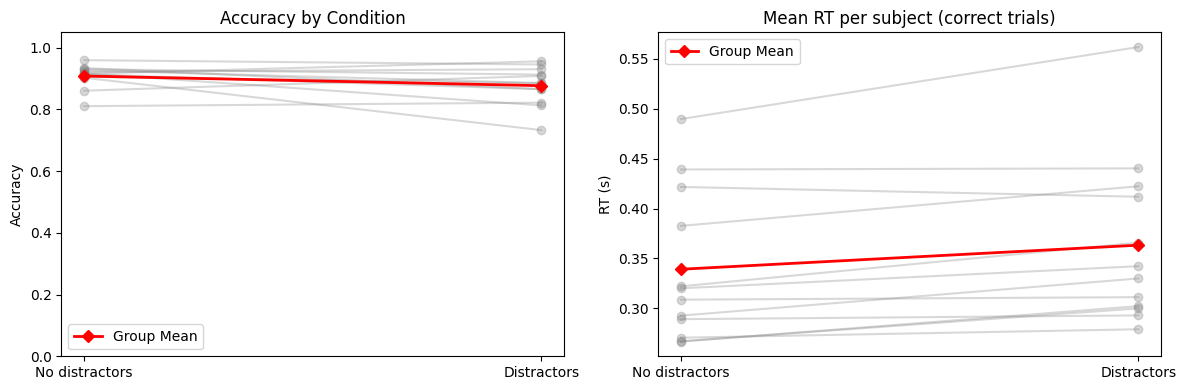

In [8]:
# ==========================================
# 6. Visualize basic behavioral effects
#    (slope plots: Accuracy & RT)
# ==========================================
subjects = sorted(summary["subjects"].unique())
cond_orders = ["absent", "present"]

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# ---------- Accuracy slope plot ----------
for subject in subjects:
    subj_data = summary[summary["subjects"] == subject].set_index("distractor").loc[cond_orders]
    axes[0].plot(
        ["No distractors", "Distractors"],
        subj_data["accuracy"].values,
        marker='o',
        color = 'grey',
        alpha=0.3,
    )

# Group Mean Accuracy
group_mean_acc = summary.groupby("distractor")["accuracy"].mean().loc[cond_orders]
axes[0].plot(["No distractors", "Distractors"], group_mean_acc.values, marker='D', color='red', linewidth=2, label='Group Mean')

axes[0].set_title("Accuracy by Condition")
axes[0].set_ylabel("Accuracy")
axes[0].set_ylim(0, 1.05)
axes[0].legend()

# ---------- RT slope plot (correct trials) ----------
for subj in subjects:
    s = summary[summary["subjects"] == subj].set_index("distractor").loc[cond_orders]
    axes[1].plot(
        ["No distractors", "Distractors"],
        s["mean_rt"].values,
        marker="o",
        color = 'grey',
        alpha=0.3
    )

# Group Mean RT
group_mean_rt = summary.groupby("distractor")["mean_rt"].mean().loc[cond_orders]
axes[1].plot(["No distractors", "Distractors"], group_mean_rt.values, marker='D', color='red', linewidth=2, label='Group Mean')

axes[1].set_title("Mean RT per subject (correct trials)")
axes[1].set_ylabel("RT (s)")
axes[1].legend()

plt.tight_layout()
plt.show()

In [9]:
# ==========================================
# 7. DDM components: hypothesis-specific classes
# ==========================================

# 7.1 Drift depends on distractor (sensory evidence hypothesis)
class DriftDistractor(pyddm.Drift):
    name = "Drift depends on distractor"
    required_parameters = ["drift_no_distractor", "drift_with_distractor"]
    required_conditions = ["distractor_code"]

    def get_drift(self, t, x, conditions, **kwargs):
        # 0 = absent, 1 = present
        if conditions['distractor_code'] == 0:
            return self.drift_no_distractor
        return self.drift_with_distractor


# 7.2 Bound depends on distractor (cautiousness hypothesis)
class BoundDistractor(pyddm.Bound):
    name = "Boundary depending on distractor presence"
    required_parameters = ["bound_no_distractor", "bound_with_distractor"]
    required_conditions = ["distractor_code"]

    def get_bound(self, t, conditions, **kwargs):
        if conditions['distractor_code'] == 0:
            return self.bound_no_distractor
        return self.bound_with_distractor


# 7.3 Start point depends on distractor (bias hypothesis)
class ICPointDistractor(pyddm.InitialCondition):
    name = "Start point depends on distractor presence"
    required_parameters = ["x0_no_distractor", "x0_with_distractor"]
    required_conditions = ["distractor_code"]

    def get_IC(self, x, dx, conditions):
        # Choose starting location depending on distractor
        if conditions['distractor_code'] == 0:
            start_loc = self.x0_no_distractor
        else:
            start_loc = self.x0_with_distractor
        # Point mass at closest grid location to start_loc
        pdf = np.zeros_like(x)
        idx = np.argmin(np.abs(x - start_loc))   # find index closest to x0
        pdf[idx] = 1.0
        return pdf


# ==========================================
# 8. Helper: build pyddm Sample per subject
# ==========================================

def build_sample_for_subject(data, subject_id):
    subj_data = data[data["subjects"] == subject_id].copy()
    # ensure choice column is present for this subject
    subj_data["choice"] = subj_data["correct"].astype(int)

    print(
        f"Subject {subject_id}: {len(subj_data)} trials, "
        f"accuracy={subj_data['correct'].mean():.3f}"
    )

    sample = Sample.from_pandas_dataframe(
        subj_data,
        rt_column_name="rt",
        choice_column_name="correct",
    )
    return sample

# ==========================================
# 9. Model factories (3 separate hypotheses)
# ==========================================

# same t0 for both conditions + uniform mixture to capture lapses
def make_mixture_overlay_single_ndt():
    return OverlayChain(
        overlays=[
            OverlayNonDecision(nondectime=Fittable(minval=0.1, maxval=0.5)),
            OverlayUniformMixture(umixturecoef=Fittable(minval=0.001, maxval=0.1)), 
        ]
    )


def create_model_drift():
    # Model 1: Only DRIFT differs between conditions; bound and bias are shared.
    return Model(
        name="DDM with drift depending on distractor",
        drift=DriftDistractor(
            drift_no_distractor=Fittable(minval=0.0, maxval=5.0),
            drift_with_distractor=Fittable(minval=0.0, maxval=5.0),
        ),
        noise=NoiseConstant(noise=1.0),
        bound=BoundConstant(B=Fittable(minval=0.3, maxval=3.0)),
        IC=ICPointSourceCenter(), 
        overlay=make_mixture_overlay_single_ndt(),
        dx=0.01, dt=0.01, T_dur=3.0,
    )


def create_model_bound():
    # Model 2: Only BOUND differs between conditions; drift and bias are shared.
    return Model(
        name="DDM with bound depending on distractor",
        drift=DriftConstant(drift=Fittable(minval=0.0, maxval=5.0)),
        noise=NoiseConstant(noise=1.0),
        bound=BoundDistractor(
            bound_no_distractor=Fittable(minval=0.3, maxval=3.0),
            bound_with_distractor=Fittable(minval=0.3, maxval=3.0),
        ),
        IC=ICPointSourceCenter(), 
        overlay=make_mixture_overlay_single_ndt(),
        dx=0.01, dt=0.01, T_dur=3.0,
    )


def create_model_bias():
    # Model 3: Only START POINT (Bias) differs between conditions; drift and bound shared.
    return Model(
        name="DDM with starting point bias depending on distractor",
        drift=DriftConstant(drift=Fittable(minval=0.0, maxval=5.0)),
        noise=NoiseConstant(noise=1.0),
        bound=BoundConstant(B=Fittable(minval=0.3, maxval=3.0)), # Min B slightly higher so x0 fits
        IC=ICPointDistractor(
             x0_no_distractor=Fittable(minval=-0.25, maxval=0.25), 
             x0_with_distractor=Fittable(minval=-0.25, maxval=0.25)
        ),
        overlay=make_mixture_overlay_single_ndt(),
        dx=0.01, dt=0.01, T_dur=3.0,
    )

In [10]:
# ==========================================
# 11. Fit the three models per subject
# ==========================================

# Helper to safely get the loss value (Fixes your TypeError)
def get_loss_value(model):
    val = model.fitresult.value
    # Check if it's a function (method) and call it if so
    if callable(val):
        return float(val())
    return float(val)

# Helper to calculate BIC
def calc_bic(nll, k, n):
    return 2 * nll + k * np.log(n)

# Helper to safely get Non-Decision Time (t0)
def get_t0(model):
    # Try accessing parameters as a dictionary (standard PyDDM)
    try:
        params = model.parameters()
        # Try OverlayChain access
        return float(params['overlay']['overlays'][0]['nondectime'])
    except:
        pass
        
    try:
        # Try direct simple overlay access
        return float(params['overlay']['nondectime'])
    except:
        pass

    # Fallback: Try accessing the component directly on the model object
    try:
        if hasattr(model.overlay, 'overlays'):
             return float(model.overlay.overlays[0].nondectime)
        else:
             return float(model.overlay.nondectime)
    except:
        # Final fallback if everything fails
        return 0.3

results = []
print(f"Fitting {len(subjects)} participants with 3 models each...\n")

for subj in subjects:
    # 1. Build Sample
    sample = build_sample_for_subject(clean_data, subj)
    n_trials = len(sample)

    # --- Fit Model 1: Drift-varying (k=5) ---
    m_v = fit_adjust_model(
        model=create_model_drift(), sample=sample, lossfunction=LossRobustLikelihood, verbose=False
    )
    p_v = m_v.parameters()
    
    # --- Fit Model 2: Bound-varying (k=5) ---
    m_a = fit_adjust_model(
        model=create_model_bound(), sample=sample, lossfunction=LossRobustLikelihood, verbose=False
    )
    p_a = m_a.parameters()

    # --- Fit Model 3: Bias-varying (k=6) ---
    m_b = fit_adjust_model(
        model=create_model_bias(), sample=sample, lossfunction=LossRobustLikelihood, verbose=False
    )
    p_b = m_b.parameters()

    results.append({
        "subject": subj,
        "best_model": None,

        # BIC Scores
        "bic_drift": calc_bic(get_loss_value(m_v), 5, n_trials),
        "bic_bound": calc_bic(get_loss_value(m_a), 5, n_trials),
        "bic_bias":  calc_bic(get_loss_value(m_b), 6, n_trials),

        # --- SAVING PARAMETERS ---
        
        # Drift Model Params
        "drift_no_distractor":   float(p_v["drift"]["drift_no_distractor"]),
        "drift_with_distractor":  float(p_v["drift"]["drift_with_distractor"]),
        "drift_B":       float(p_v["bound"]["B"]),
        "drift_t0":      get_t0(m_v),

        # Bound Model Params
        "bound_no_distractor":   float(p_a["bound"]["bound_no_distractor"]),
        "bound_with_distractor":  float(p_a["bound"]["bound_with_distractor"]),
        "bound_v":       float(p_a["drift"]["drift"]),
        "bound_t0":      get_t0(m_a),

        # Bias Model Params
        "x0_no_distractor":   float(p_b["IC"]["x0_no_distractor"]),
        "x0_with_distractor":  float(p_b["IC"]["x0_with_distractor"]),
        "bias_v":        float(p_b["drift"]["drift"]),
        "bias_B":        float(p_b["bound"]["B"]),
        "bias_t0":       get_t0(m_b),
    })

res_df = pd.DataFrame(results)

# Identify winning model
res_df["best_model"] = res_df[["bic_drift", "bic_bound", "bic_bias"]].idxmin(axis=1)
res_df["best_model"] = res_df["best_model"].str.replace("bic_", "")

print("\nFitting complete. Results stored in 'res_df'.")
print(res_df[['subject', 'best_model', 'bic_drift', 'bic_bound', 'bic_bias']].head())

Fitting 12 participants with 3 models each...

Subject 1: 460 trials, accuracy=0.926


Info: Params [2.73091509e+00 2.23014001e+00 5.49732534e-01 1.51973486e-01
 1.00000000e-03] gave -280.36349268991546
Info: Params [2.45755954e+00 5.13979664e-01 5.86969388e-01 1.52744080e-01
 1.00000000e-03] gave -282.6941846241238
Info: Params [ 2.61410134e+00  4.98010806e-01  2.47050836e-02 -5.86512572e-02
  1.66942646e-01  1.00000000e-03] gave -282.97910984043074


Subject 2: 407 trials, accuracy=0.936


Info: Params [2.27303130e+00 2.44753154e+00 5.46325366e-01 1.16437663e-01
 1.00000000e-03] gave -217.60983601344438
Info: Params [2.36154090e+00 5.40189190e-01 5.52079827e-01 1.15191186e-01
 1.00000000e-03] gave -217.44615497573156
Info: Params [2.16580788e+00 5.19354333e-01 5.01302786e-02 7.03619682e-02
 1.20323870e-01 1.00000000e-03] gave -215.9468529151103


Subject 3: 402 trials, accuracy=0.953


Info: Params [3.01751853e+00 2.80236243e+00 4.94412328e-01 1.25786858e-01
 1.00000000e-03] gave -347.75121091268034
Info: Params [2.90243892e+00 4.95014078e-01 4.92108753e-01 1.23722682e-01
 1.00000000e-03] gave -347.4095179091756
Info: Params [2.27252742e+00 4.41655423e-01 1.19096599e-01 1.25780725e-01
 1.42103039e-01 1.00000000e-03] gave -344.7584581799313


Subject 4: 437 trials, accuracy=0.817


Info: Params [1.81237895e+00 8.50596121e-01 5.87864741e-01 1.13226457e-01
 1.00000000e-03] gave 33.898775287895205
Info: Params [1.25120135e+00 5.64971965e-01 5.95146126e-01 1.12854728e-01
 1.00000000e-03] gave 47.33317259982824
Info: Params [ 1.23440816e+00  5.57221502e-01  6.35889756e-02 -1.65886841e-02
  1.20998933e-01  1.00000000e-03] gave 49.82441427461036


Subject 5: 339 trials, accuracy=0.906


Info: Params [2.72941176e+00 2.05093874e+00 4.74431646e-01 1.23771195e-01
 1.00000000e-03] gave -224.4716520417757
Info: Params [2.33200841e+00 4.54596593e-01 4.89223297e-01 1.21170459e-01
 1.00000000e-03] gave -222.66662954587855
Info: Params [2.14246397e+00 4.38681776e-01 7.83794192e-02 1.78288650e-02
 1.33064967e-01 1.00000000e-03] gave -221.98832095254508


Subject 6: 460 trials, accuracy=0.865


Info: Params [2.23533442e+00 1.22245664e+00 5.88317924e-01 2.76342483e-01
 1.00000000e-03] gave -67.74388549234885
Info: Params [1.62694961 0.55124291 0.60583477 0.27200306 0.00254847] gave -56.143830970183956
Info: Params [ 1.78415519  0.54166684  0.04347708 -0.06786925  0.28376729  0.00636653] gave -59.21594800264168


Subject 7: 460 trials, accuracy=0.885


Info: Params [1.84942292e+00 2.19228440e+00 4.91893451e-01 2.37754604e-01
 1.00000000e-03] gave -211.10629114010135
Info: Params [2.01467222e+00 4.95635836e-01 4.87160662e-01 2.31779724e-01
 1.00000000e-03] gave -209.9268644999307
Info: Params [ 2.14056014e+00  4.77450859e-01 -3.27673243e-02  8.03304196e-03
  2.34174134e-01  1.00000000e-03] gave -209.56415708282893


Subject 8: 399 trials, accuracy=0.890


Info: Params [2.60629056e+00 1.93084345e+00 4.70091884e-01 1.25315295e-01
 1.00000000e-03] gave -255.04084323616948
Info: Params [2.22163688e+00 4.50768525e-01 4.85877590e-01 1.28997548e-01
 1.00000000e-03] gave -252.90942419752693
Info: Params [2.07545329e+00 4.32649920e-01 9.28875415e-02 4.32483469e-05
 1.36563965e-01 1.00000000e-03] gave -254.19964204131327


Subject 9: 344 trials, accuracy=0.895


Info: Params [2.22246868e+00 2.10692375e+00 4.73104635e-01 1.20585879e-01
 1.00000000e-03] gave -193.81835161277243
Info: Params [2.16371031e+00 4.74287849e-01 4.71879092e-01 1.24282968e-01
 1.00000000e-03] gave -193.72548563525186
Info: Params [1.75601662e+00 4.57306517e-01 9.01497781e-02 9.56571915e-02
 1.38138402e-01 1.00000000e-03] gave -195.08546430548017


Subject 10: 414 trials, accuracy=0.816


Info: Params [1.53299491 1.46976612 0.49228792 0.12769855 0.00295726] gave -89.09189765325948
Info: Params [1.49936138 0.48160154 0.50399856 0.1235391  0.00251422] gave -89.67965447947788
Info: Params [ 1.60039474e+00  4.76490179e-01  1.44142766e-03 -1.73527893e-02
  1.29969630e-01  4.37796654e-03] gave -86.45033814266725


Subject 11: 460 trials, accuracy=0.922


Info: Params [2.41844235e+00 2.30527432e+00 5.28273989e-01 2.51639326e-01
 1.00000000e-03] gave -268.41077894465093
Info: Params [2.36376973e+00 5.34836045e-01 5.22261884e-01 2.57939630e-01
 1.00000000e-03] gave -268.4438885449216
Info: Params [2.30537629e+00 4.81651463e-01 1.92639462e-02 2.74660692e-02
 2.61683589e-01 1.00000000e-03] gave -266.0298611700147


Subject 12: 399 trials, accuracy=0.900


Info: Params [2.52099934e+00 1.74889215e+00 4.92961799e-01 1.28169859e-01
 1.00000000e-03] gave -194.7044841319293
Info: Params [2.07644581e+00 4.77653142e-01 5.01484882e-01 1.28068569e-01
 1.00000000e-03] gave -189.91520039798618
Info: Params [1.73235081e+00 4.64423990e-01 1.10632175e-01 5.73899911e-02
 1.38680460e-01 1.00000000e-03] gave -188.54151334414092



Fitting complete. Results stored in 'res_df'.
   subject best_model   bic_drift   bic_bound    bic_bias
0        1      bound -530.070853 -534.732237 -529.170861
1        2      drift -405.175606 -404.848244 -395.840827
2        3      drift -665.520161 -664.836775 -653.538204
3        4      drift   98.197217  125.066011  136.128428
4        5      drift -419.813304 -416.203259 -409.020641



--- Parameter differences across conditions ---


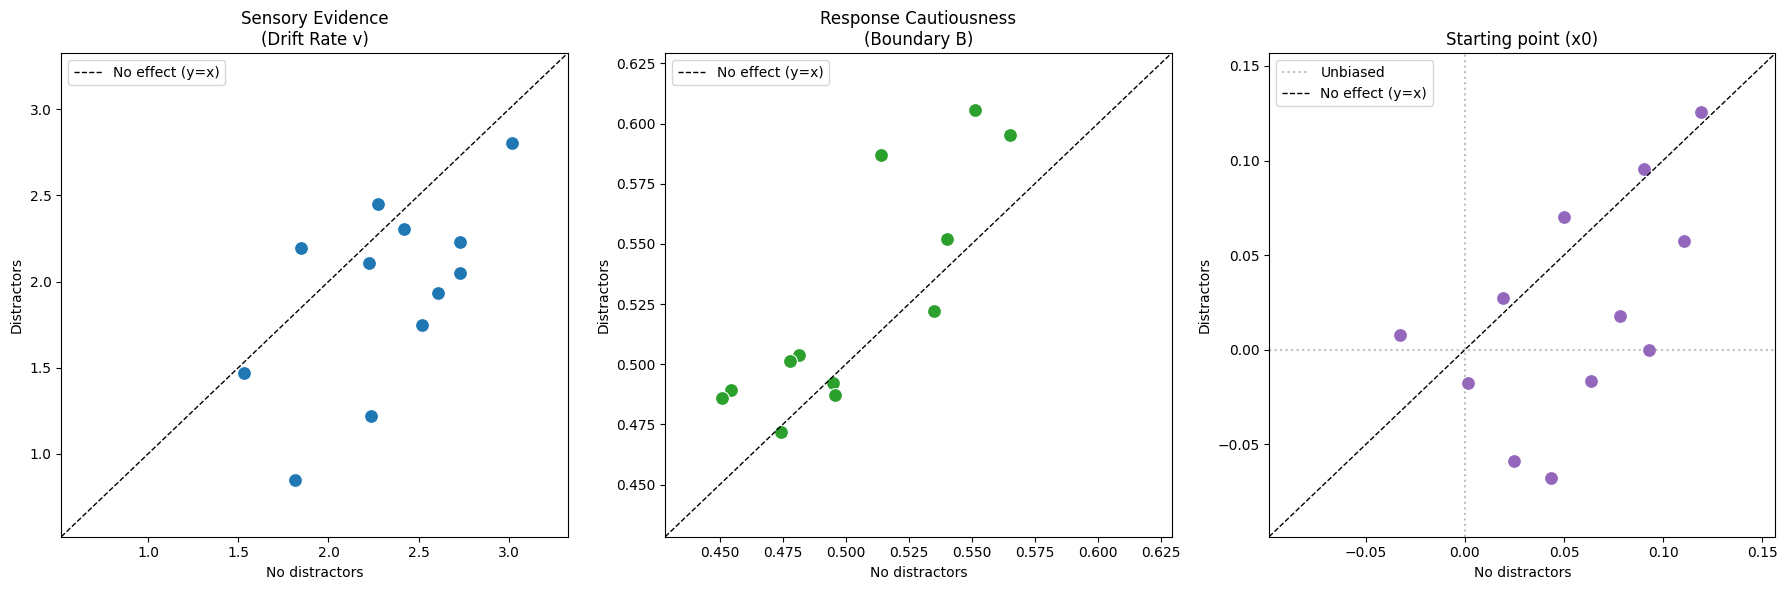

In [11]:
# ==========================================
# 12. Visualize fitted parameters (per model, per subject)
#    - Scatter plots (present vs absent)
#    - Slope plots (per subject + group mean)
# ==========================================
print("\n--- Parameter differences across conditions ---")

# Make x and y axis use the same limits and add a y=x 'no effect' line
# Makes it easy to see condition effects relative to no-difference
def set_square_limits(ax, padding=0.1):
    xmin, xmax = ax.get_xlim()
    ymin, ymax = ax.get_ylim()
    
    lo = min(xmin, ymin)
    hi = max(xmax, ymax)
    
    # Add padding
    rng = hi - lo
    lo -= padding * rng
    hi += padding * rng
    
    ax.set_xlim(lo, hi)
    ax.set_ylim(lo, hi)
    
    # Plot the unity line (x=y) across this dynamic range
    ax.plot([lo, hi], [lo, hi], 'k--', linewidth=1, label="No effect (y=x)")

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 12.1 Scatter plots: parameter values in both conditions


# Sensory Evidence (Drift Rate)
# Points below the diagonal -> Drift decreases with distractors (Interference)
sns.scatterplot(
    data=res_df, x="drift_no_distractor", y="drift_with_distractor",
    s=100, color="C0", ax=axes[0]
)
axes[0].set_title("Sensory Evidence\n(Drift Rate v)")
axes[0].set_xlabel("No distractors")
axes[0].set_ylabel("Distractors")
set_square_limits(axes[0])
axes[0].legend()


# Response Cautiousness (Boundary)
# Points above diagonal -> Caution increases with distractors
sns.scatterplot(
    data=res_df, x="bound_no_distractor", y="bound_with_distractor",
    s=100, color="C2", ax=axes[1]
)
axes[1].set_title("Response Cautiousness\n(Boundary B)")
axes[1].set_xlabel("No distractors")
axes[1].set_ylabel("Distractors")
set_square_limits(axes[1])
axes[1].legend()

# Response Bias (Starting Point)
# Points away from 0 indicate bias
sns.scatterplot(
    data=res_df, x="x0_no_distractor", y="x0_with_distractor",
    s=100, color="C4", ax=axes[2]
)
axes[2].set_title("Starting point (x0)")
axes[2].set_xlabel("No distractors")
axes[2].set_ylabel("Distractors")
# Add reference lines for "Unbiased" (0,0)
axes[2].axhline(0, color='gray', linestyle=':', alpha=0.5, label='Unbiased')
axes[2].axvline(0, color='gray', linestyle=':', alpha=0.5)

set_square_limits(axes[2])
axes[2].legend()

plt.tight_layout()
plt.show()

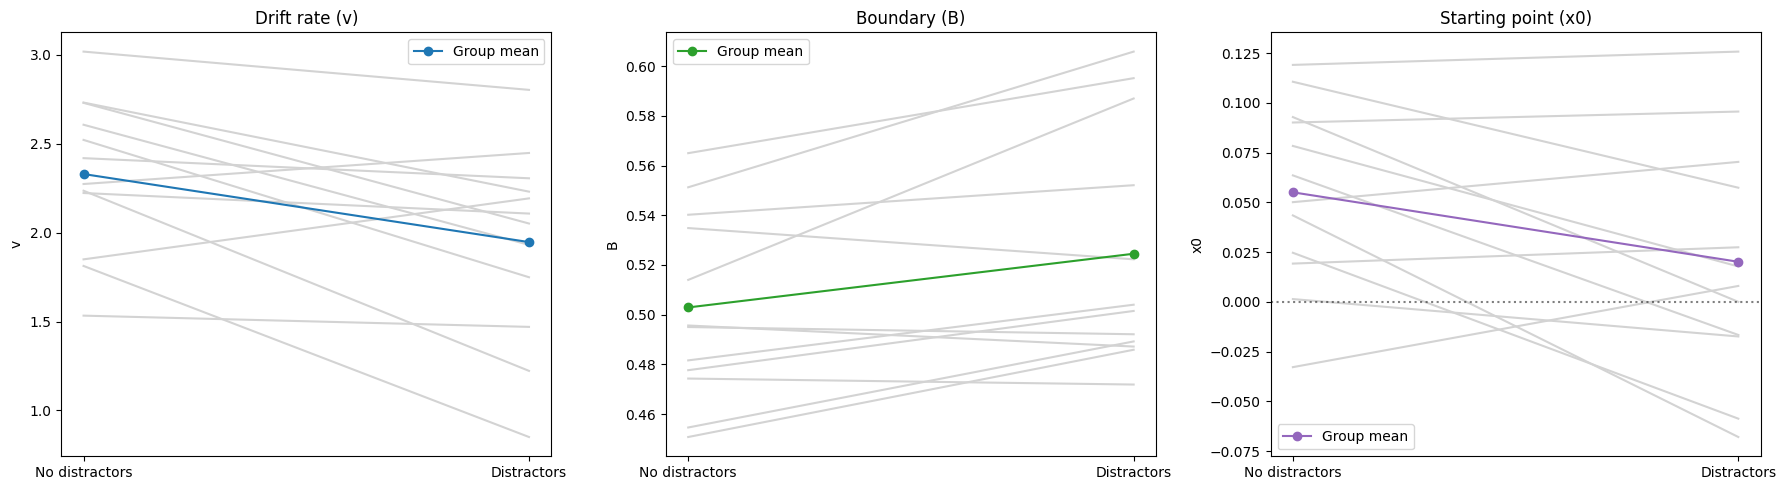

In [12]:
# 12.2 Slope-style plots: per subject + group mean
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Individual subject lines
for _, row in res_df.iterrows():
    axes[0].plot([0, 1], [row["drift_no_distractor"], row["drift_with_distractor"]], color="lightgray")
    axes[1].plot([0, 1], [row["bound_no_distractor"], row["bound_with_distractor"]], color="lightgray")
    axes[2].plot([0, 1], [row["x0_no_distractor"], row["x0_with_distractor"]], color="lightgray")

# Group mean lines
axes[0].plot([0, 1],
             [res_df["drift_no_distractor"].mean(), res_df["drift_with_distractor"].mean()],
             "-o", color="C0", label="Group mean")
axes[1].plot([0, 1],
             [res_df["bound_no_distractor"].mean(), res_df["bound_with_distractor"].mean()],
             "-o", color="C2", label="Group mean")
axes[2].plot([0, 1],
             [res_df["x0_no_distractor"].mean(), res_df["x0_with_distractor"].mean()],
             "-o", color="C4", label="Group mean")

for ax, title, ylabel in zip(
    axes,
    ["Drift rate (v)", "Boundary (B)", "Starting point (x0)"],
    ["v", "B", "x0"]
):
    ax.set_xticks([0, 1])
    ax.set_xticklabels(["No distractors", "Distractors"])
    ax.set_title(title)
    ax.set_ylabel(ylabel)

axes[0].legend()
axes[1].legend()
axes[2].legend()

# Zero line for bias parameter
axes[2].axhline(0, color='black', linestyle=':', alpha=0.5)

plt.tight_layout()
plt.show()


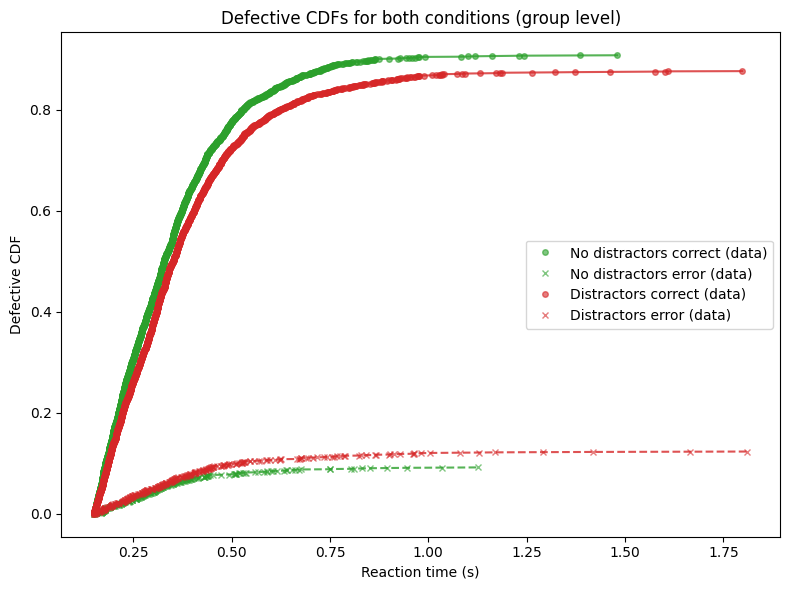

In [13]:
# ==========================================
# 13. Defective CDFs (group-level, data only)
# ==========================================
def plot_defective_cdf_one_condition(data, condition_col, condition_val, label, color, ax):
    # Plot defective CDF for one condition (correct + error).
    subset = data[data[condition_col] == condition_val]

    # RTs for correct vs error
    rt_corr = subset[subset["correct"] == 1]["rt"].values
    rt_err  = subset[subset["correct"] == 0]["rt"].values

    if len(rt_corr) > 0:
        rt_corr = np.sort(rt_corr)
    if len(rt_err) > 0:
        rt_err = np.sort(rt_err)

    # Total trials for defective scaling
    n_total = len(subset)
    p_corr = len(rt_corr) / n_total if n_total > 0 else 0.0
    p_err  = len(rt_err)  / n_total if n_total > 0 else 0.0

    # Defective CDF for correct trials
    if len(rt_corr) > 0:
        y_corr = (np.arange(1, len(rt_corr) + 1) / len(rt_corr)) * p_corr
        ax.plot(rt_corr, y_corr, "o", color=color, alpha=0.6,
                markersize=4, label=f"{label} correct (data)")
        ax.plot(rt_corr, y_corr, "-", color=color, alpha=0.8)

    # Defective CDF for error trials
    if len(rt_err) > 0:
        y_err = (np.arange(1, len(rt_err) + 1) / len(rt_err)) * p_err
        ax.plot(rt_err, y_err, "x", color=color, alpha=0.6,
                markersize=4, label=f"{label} error (data)")
        ax.plot(rt_err, y_err, "--", color=color, alpha=0.8)


fig, ax = plt.subplots(figsize=(8, 6))

# # Condition 2 = no distractors ("absent"), Condition 1 = distractors ("present")
plot_defective_cdf_one_condition(
    clean_data, "distractor", "absent", "No distractors", "tab:green", ax
)
plot_defective_cdf_one_condition(
    clean_data, "distractor", "present", "Distractors", "tab:red", ax
)

ax.set_xlabel("Reaction time (s)")
ax.set_ylabel("Defective CDF")
ax.set_title("Defective CDFs for both conditions (group level)")
ax.legend()
plt.tight_layout()
plt.show()

In [14]:
# ==========================================
# 14. Group-level parameter summary & difference scores
# ==========================================
param_cols = ["drift_no_distractor", "drift_with_distractor",
              "bound_no_distractor", "bound_with_distractor",
              "x0_no_distractor", "x0_with_distractor"]
summary_table = res_df[param_cols].describe().loc[["mean", "std"]]
print(summary_table)

# Difference scores (present - absent)
res_df["v_diff"]  = res_df["drift_with_distractor"]  - res_df["drift_no_distractor"]
res_df["B_diff"]  = res_df["bound_with_distractor"]  - res_df["bound_no_distractor"]
res_df["x0_diff"] = res_df["x0_with_distractor"] - res_df["x0_no_distractor"]

print("\nMean difference scores (present - absent):")
print(f"Δv   (drift)    : {res_df['v_diff'].mean():.4f}")
print(f"ΔB   (bound)    : {res_df['B_diff'].mean():.4f}")
print(f"Δx0  (bias)     : {res_df['x0_diff'].mean():.4f}")

      drift_no_distractor  drift_with_distractor  bound_no_distractor  \
mean             2.329101               1.946501             0.502898   
std              0.433951               0.546191             0.037898   

      bound_with_distractor  x0_no_distractor  x0_with_distractor  
mean               0.524502          0.055082            0.020175  
std                0.047838          0.046140            0.058845  

Mean difference scores (present - absent):
Δv   (drift)    : -0.3826
ΔB   (bound)    : 0.0216
Δx0  (bias)     : -0.0349


Winning models per subject:
     subject best_model
0         1      bound
1         2      drift
2         3      drift
3         4      drift
4         5      drift
5         6      drift
6         7      drift
7         8      drift
8         9      drift
9        10      bound
10       11      bound
11       12      drift

Counts of winning models:
 best_model
drift    9
bound    3
Name: count, dtype: int64


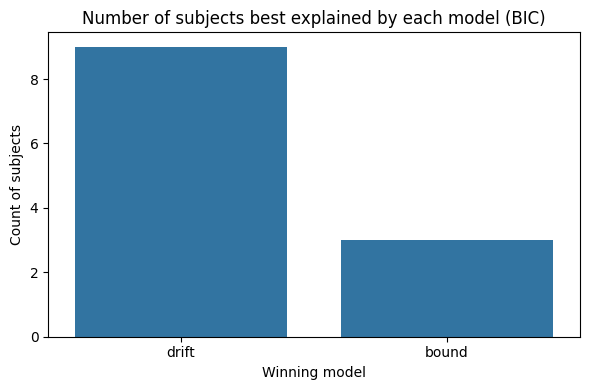


Interpretation hint (for your report):
- Drift model wins: 9 subjects
- Bound model wins: 3 subjects
- Bias model wins : 0 subjects
Inference: the model type with the highest count is the best candidate
for explaining how distractors affect behaviour (sensory evidence vs
cautiousness vs response bias). No additional t-tests are needed.


In [15]:
# ==========================================
# 15. Model comparison via BIC 
# ==========================================

win_counts = res_df["best_model"].value_counts()
print("Winning models per subject:\n", res_df[["subject", "best_model"]])
print("\nCounts of winning models:\n", win_counts)

plt.figure(figsize=(6, 4))
sns.barplot(
    x=win_counts.index,
    y=win_counts.values,
)
plt.title("Number of subjects best explained by each model (BIC)")
plt.xlabel("Winning model")
plt.ylabel("Count of subjects")
plt.tight_layout()
plt.show()

print("\nInterpretation hint (for your report):")
print(f"- Drift model wins: {win_counts.get('drift', 0)} subjects")
print(f"- Bound model wins: {win_counts.get('bound', 0)} subjects")
print(f"- Bias model wins : {win_counts.get('bias', 0)} subjects")
print("Inference: the model type with the highest count is the best candidate")
print("for explaining how distractors affect behaviour (sensory evidence vs")
print("cautiousness vs response bias). No additional t-tests are needed.")


--- STEP 16: Predictive Checks (Observed vs. Predicted) ---


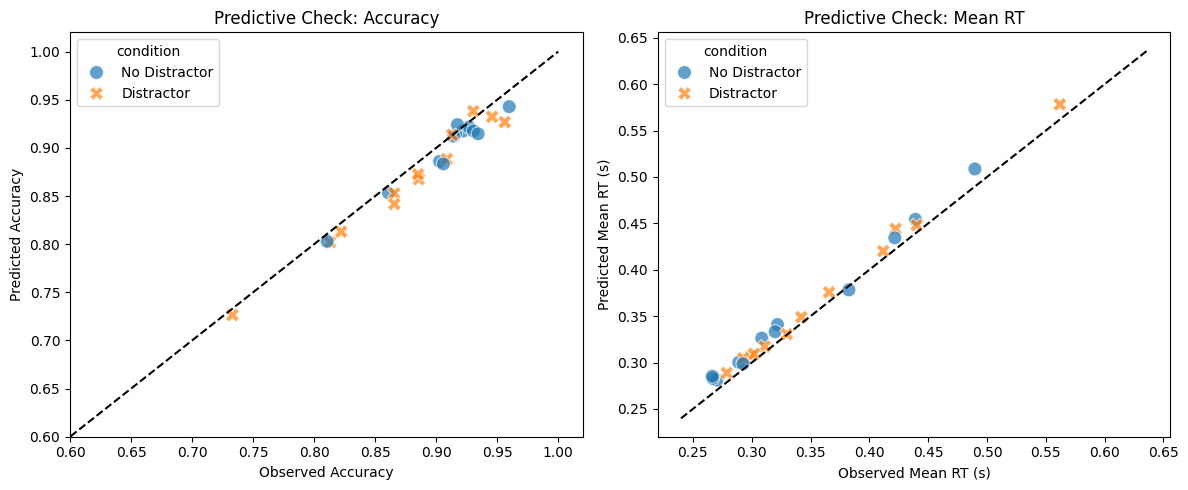

In [16]:
# ==========================================
# STEP 16: Predictive Checks (Fixed & Verified)
# ==========================================

print("\n--- STEP 16: Predictive Checks (Observed vs. Predicted) ---")

def safe_t0(value, default=0.3):
    """Return a clean non-decision time (float, no NaNs, non-negative)."""
    try:
        v = float(value)
    except (TypeError, ValueError):
        return default
    if not np.isfinite(v) or v < 0:
        return default
    return v


def make_overlay_for_prediction(t0):
    """Simple overlay: fixed non-decision + small lapse."""
    return OverlayChain(overlays=[
        OverlayNonDecision(nondectime=t0),
        OverlayUniformMixture(umixturecoef=0.02),
    ])


def reconstruct_winning_model(row):
    """
    Rebuild the winning DDM per subject using the SUBJECT-SPECIFIC
    parameters saved in res_df (Block 11).
    """
    model_type = row["best_model"]

    if model_type == "drift":
        t0 = safe_t0(row.get("drift_t0", 0.3))
        return Model(
            drift=DriftDistractor(
                drift_no_distractor=row["drift_no_distractor"],
                drift_with_distractor=row["drift_with_distractor"],
            ),
            noise=NoiseConstant(noise=1.0),
            bound=BoundConstant(B=row["drift_B"]),
            IC=ICPointSourceCenter(),
            overlay=make_overlay_for_prediction(t0),
            dx=0.01, dt=0.01, T_dur=3.0,
        )

    elif model_type == "bound":
        t0 = safe_t0(row.get("bound_t0", 0.3))
        return Model(
            drift=DriftConstant(drift=row["bound_v"]),
            noise=NoiseConstant(noise=1.0),
            bound=BoundDistractor(
                bound_no_distractor=row["bound_no_distractor"],
                bound_with_distractor=row["bound_with_distractor"],
            ),
            IC=ICPointSourceCenter(),
            overlay=make_overlay_for_prediction(t0),
            dx=0.01, dt=0.01, T_dur=3.0,
        )

    else:  # "bias"
        t0 = safe_t0(row.get("bias_t0", 0.3))
        return Model(
            drift=DriftConstant(drift=row["bias_v"]),
            noise=NoiseConstant(noise=1.0),
            bound=BoundConstant(B=row["bias_B"]),
            IC=ICPointDistractor(
                x0_no_distractor=row["x0_no_distractor"],
                x0_with_distractor=row["x0_with_distractor"],
            ),
            overlay=make_overlay_for_prediction(t0),
            dx=0.01, dt=0.01, T_dur=3.0,
        )


def get_model_predictions(model, condition_code):
    """
    Simulate the model to get predicted Accuracy and Mean RT (correct trials).
    """
    sol = model.solve(conditions={"distractor_code": condition_code})
    
    # Probability of correct response
    pred_acc = sol.prob('correct')
    
    # Your pyddm version: mean_decision_time() takes no arguments
    if pred_acc > 0:
        pred_rt = sol.mean_decision_time()
    else:
        pred_rt = np.nan

    return pred_acc, pred_rt


# --- Run Predictive Checks ---
pred_list = []

for _, row in res_df.iterrows():
    subj = row["subject"]
    subj_df = clean_data[clean_data["subjects"] == subj]

    try:
        model = reconstruct_winning_model(row)

        for cond_code, cond_label in zip([0, 1], ["No Distractor", "Distractor"]):
            cond_data = subj_df[subj_df["distractor_code"] == cond_code]
            if len(cond_data) == 0:
                continue

            emp_acc = cond_data["correct"].mean()
            emp_rt = cond_data[cond_data["correct"] == 1]["rt"].mean()

            pred_acc, pred_rt = get_model_predictions(model, cond_code)

            pred_list.append(
                {
                    "subject": subj,
                    "condition": cond_label,
                    "emp_acc": emp_acc,
                    "emp_rt": emp_rt,
                    "pred_acc": pred_acc,
                    "pred_rt": pred_rt,
                }
            )

    except Exception as e:
        print(f"Skipping subject {subj} due to error: {e}")

if not pred_list:
    print("Error: No data generated. All subjects skipped.")
else:
    pred_df = pd.DataFrame(pred_list)

    # --- Plotting ---
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy
    sns.scatterplot(
        data=pred_df,
        x="emp_acc",
        y="pred_acc",
        hue="condition",
        style="condition",
        s=100,
        alpha=0.7,
        ax=axes[0],
    )
    axes[0].plot([0, 1], [0, 1], "k--", label="Perfect Fit")
    axes[0].set_title("Predictive Check: Accuracy")
    axes[0].set_xlabel("Observed Accuracy")
    axes[0].set_ylabel("Predicted Accuracy")
    axes[0].set_xlim(0.6, 1.02)
    axes[0].set_ylim(0.6, 1.02)

    # RT
    sns.scatterplot(
        data=pred_df,
        x="emp_rt",
        y="pred_rt",
        hue="condition",
        style="condition",
        s=100,
        alpha=0.7,
        ax=axes[1],
    )
    min_rt = pred_df[["emp_rt", "pred_rt"]].min().min() * 0.9
    max_rt = pred_df[["emp_rt", "pred_rt"]].max().max() * 1.1
    axes[1].plot([min_rt, max_rt], [min_rt, max_rt], "k--", label="Perfect Fit")
    axes[1].set_title("Predictive Check: Mean RT")
    axes[1].set_xlabel("Observed Mean RT (s)")
    axes[1].set_ylabel("Predicted Mean RT (s)")

    plt.tight_layout()
    plt.show()
